# Projet 07 : Effectuer une prédiction de revenus

---
**Importation des librairies**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.colors as plc
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
import modules_perso.sf_graphiques as sfg

---
## <font color=blue>Mission 4 : Modélisation du revenu des individus</font>

### 4.4.  ANOVA du revenu basée sur le revenu moyen et l'indice de Gini du pays de l'individu

In [4]:
data = pd.read_csv("data_analyse03.csv", index_col=0)
data.head()

C:\Anaconda3\envs\Jupyter\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,child_income,revenu_moyen,gini_from_centiles
0,728.89795,2994.829902,32.141019
1,728.89795,2994.829902,32.141019
2,728.89795,2994.829902,32.141019
3,728.89795,2994.829902,32.141019
4,728.89795,2994.829902,32.141019


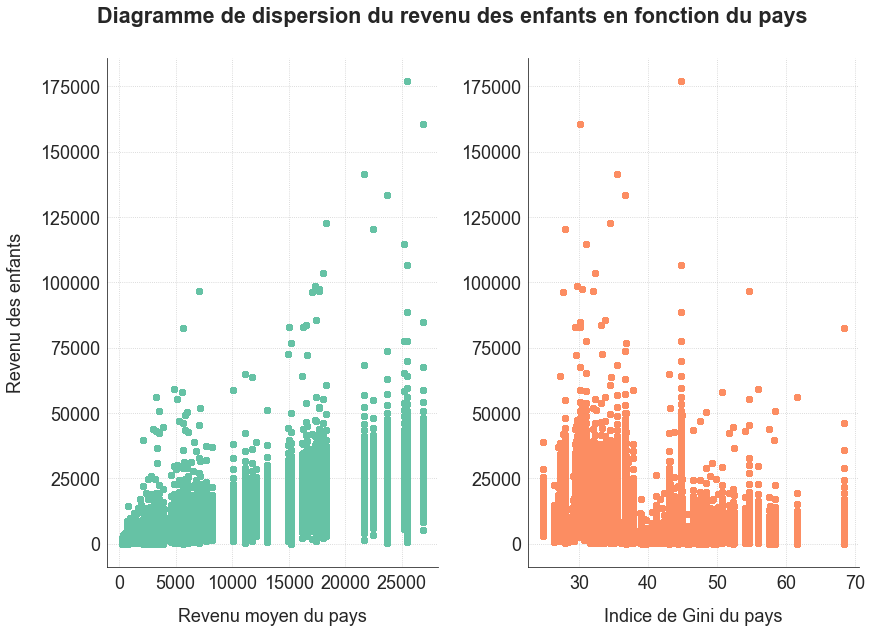

In [5]:
mygraph = sfg.MyGraph("Diagramme de dispersion du revenu des enfants en fonction du pays", nblin=1, nbcol=2, is_mono=False)
mygraph.add_plot(data.revenu_moyen, data.child_income, label="", marker='o', markeredgecolor=mygraph.liste_couleurs[0], markerfacecolor=mygraph.liste_couleurs[0], linestyle='', with_grid='both', grid_style=":", multi_index=1)
mygraph.add_plot(data.gini_from_centiles, data.child_income, label="", marker='o', markeredgecolor=mygraph.liste_couleurs[1], markerfacecolor=mygraph.liste_couleurs[1], linestyle='', with_grid='both', grid_style=":", multi_index=2)
mygraph.set_axe('x', label="Revenu moyen du pays", multi_index=1)
mygraph.set_axe('x', label="Indice de Gini du pays", multi_index=2)
mygraph.set_axe('y', label="Revenu des enfants", multi_index=1)
fig, ax = mygraph.fig, mygraph.ax
plt.savefig("anova03_00_diagramme_dispersion.png")
plt.show()

Le nuage de points des revenus des enfants montre une grande diversité des situations, que ce soit face au revenu moyen ou à l'indice de Gini.  
On remarque malgré tout que le revenu des enfants semble croître lorsque le revenu moyen du pays augmente, ce qui semble totalement logique. La relation avec l'indice de Gini est moins évidente graphiquement.  
La forte dispersion des revenus laisse une nouvelle fois présager des difficultés de modélisation par un modèle linéaire.

In [6]:
anova = smf.ols(formula="child_income ~ revenu_moyen + gini_from_centiles", data=data).fit()

In [7]:
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           child_income   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                 2.750e+06
Date:                Fri, 11 Oct 2019   Prob (F-statistic):               0.00
Time:                        10:18:33   Log-Likelihood:            -5.7765e+07
No. Observations:             5642420   AIC:                         1.155e+08
Df Residuals:                 5642417   BIC:                         1.155e+08
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              8.6359     15.091      0.572      0.567     -20.941      38.213
revenu_moyen           0.9996      0.000   2181.972      0.000       0.999       1.000
gini_from_centiles    -0.2200      0.342     -0.643      0.520      -0.890       0.450
==============================================================================
Omnibus:                  7043758.832   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1943773157.718
Skew:                           6.653   Prob(JB):                         0.00
Kurtosis:                      92.949   Cond. No.                     4.83e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.83e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [8]:
table_anova = sm.stats.anova_lm(anova, typ=2)
table_anova.loc["total","sum_sq"] = table_anova.loc[:,"sum_sq"].sum()
table_anova.loc["total","df"] = table_anova.loc[:,"df"].sum()
table_anova["eta_squared"] = table_anova[:-2]["sum_sq"] / table_anova.loc["total","sum_sq"]
cmr = table_anova["sum_sq"][-1] / table_anova["df"][-1]
table_anova["omega_squared"] = (table_anova[:-2]["sum_sq"] - (table_anova[:-2]["df"] * cmr)) / (table_anova.loc["total","sum_sq"] + cmr)
table_anova

,sum_sq,df,F,PR(>F),eta_squared,omega_squared
revenu_moyen,2.175092e+14,1.0,4.761002e+06,0.000000,4.576382e-01,4.576379e-01
gini_from_centiles,1.890413e+07,1.0,4.137876e-01,0.520053,3.977419e-08,-1.374547e-07
Residual,2.577772e+14,5642417.0,NaN,NaN,NaN,NaN
total,4.752864e+14,5642419.0,NaN,NaN,NaN,NaN


La part de dispersion expliquée par le modèle est similaire au premier modèle : 49,4%. Elle est peu satisfaisante. De même, nous retrouvons les mêmes AIC et BIC que ceux du premier modèle. Nous pouvons craindre à nouveau un manque de linéarité de la relation.  
L'ANOVA montre que seul le revenu moyen est significatif.  
Avant d'analyser le modèle,  il faut vérifier le respect des hypothèses sur la normalité des résidus, la linéarité de la relation et l'homoscédasticité.

### Vérification des hypothèses

**Hypothèse 1 : Normalité des résidus**

In [9]:
alpha_normalite = 0.05
ad_stat, ad_pvalue = sm.stats.normal_ad(anova.resid)
norm_stat, norm_pvalue = st.kstest(anova.resid, cdf='norm', args=(anova.resid.mean(), anova.resid.var(ddof=1)))
jb_stat, jb_pvalue, skw, kurt = sm.stats.stattools.jarque_bera(anova.resid)
df_normalite = pd.DataFrame({'H0':np.repeat("Distribution normale",3), 'Statistique':["{:.2f}".format(ad_stat),"{:.2f}".format(norm_stat),"{:.2f}".format(jb_stat)], \
                             'p-value':["{:.3f}".format(ad_pvalue),"{:.3f}".format(norm_pvalue),"{:.3f}".format(jb_pvalue)]}, index=["Anderson-Darling","Kolmogorov-Smirnov","Jarque-Bera"])
inter_col = "Résultat (seuil={:.1%})".format(alpha_normalite)
df_normalite[inter_col] = ["Normalité acceptée" if float(pval)>=alpha_normalite else "Normalité rejetée" for pval in df_normalite["p-value"]]
df_normalite

C:\Anaconda3\envs\Jupyter\lib\site-packages\statsmodels\stats\_adnorm.py:66: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  S = np.sum((2*i[sl1]-1.0)/N*(np.log(z)+np.log(1-z[sl2])), axis=axis)
C:\Anaconda3\envs\Jupyter\lib\site-packages\statsmodels\stats\_adnorm.py:66: RuntimeWarning: divide by zero encountered in log
  S = np.sum((2*i[sl1]-1.0)/N*(np.log(z)+np.log(1-z[sl2])), axis=axis)


,H0,Statistique,p-value,Résultat (seuil=5.0%)
Anderson-Darling,Distribution normale,inf,0.000,Normalité rejetée
Kolmogorov-Smirnov,Distribution normale,0.50,0.000,Normalité rejetée
Jarque-Bera,Distribution normale,1943773157.72,0.000,Normalité rejetée


Aucun des trois test n'accepte la normalité. Nous avons un grand nombre d'observations. Une symétrie de la distribution des résidus sera suffisante. Je vérifie graphiquement cette symétrie, et je trace également la droite de Henry.

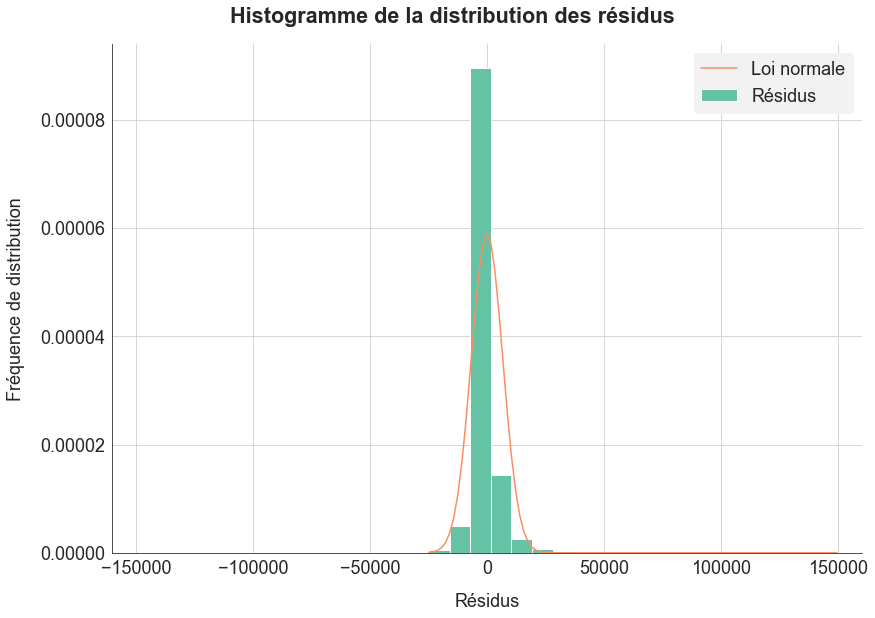

In [10]:
x_theo = np.arange(anova.resid.min(), anova.resid.max(), 0.01*(anova.resid.max()-anova.resid.min()))
mygraph = sfg.MyGraph("Histogramme de la distribution des résidus", is_mono=False)
mygraph.add_histogramme(anova.resid, bins=20, labels="Résidus")
mygraph.add_plot(x_theo, st.norm.pdf(x_theo, scale=anova.resid.std(ddof=1)), label="Loi normale", legend=True)
xmin, xmax = mygraph.ax[0].get_xlim()
absmax = max(-xmin, xmax)
mygraph.set_axe('y', label="Fréquence de distribution")
mygraph.set_axe('x', label="Résidus", tick_min=-absmax, tick_max=absmax)
fig, ax = mygraph.fig, mygraph.ax
plt.savefig("anova03_01_distribution_residus.png")
plt.show()

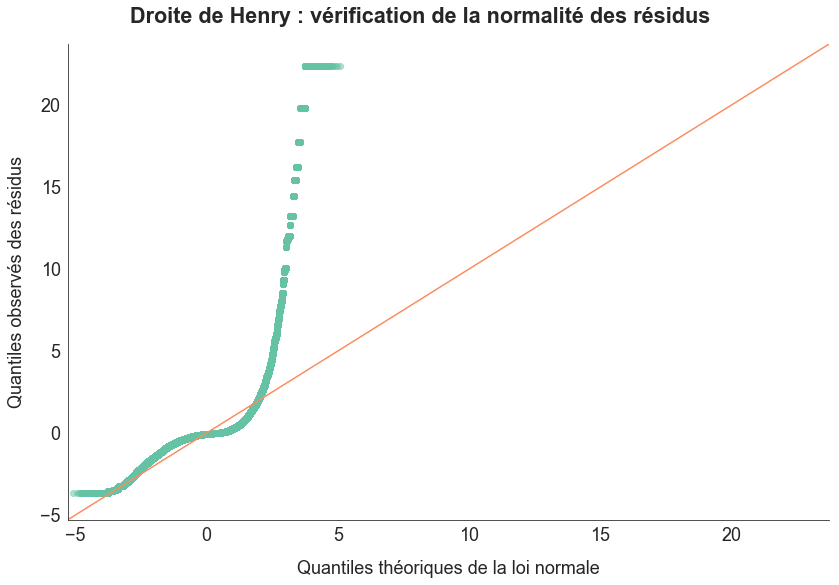

In [11]:
mygraph = sfg.MyGraph("Droite de Henry : vérification de la normalité des résidus", is_mono=False)
sm.qqplot(anova.resid, fit=True, markeredgecolor=mygraph.liste_couleurs[0], markerfacecolor=mygraph.liste_couleurs[0], alpha=0.5, ax=mygraph.ax[0])
ymin, ymax = mygraph.ax[0].get_ylim()
xmin, xmax = mygraph.ax[0].get_xlim()
data_min = min(xmin, ymin)
data_max = max(xmax, ymax)
mygraph.add_plot([data_min, data_max], [data_min, data_max], label="", color=mygraph.liste_couleurs[1])
mygraph.set_axe('x', label="Quantiles théoriques de la loi normale")
mygraph.set_axe('y', label="Quantiles observés des résidus")
mygraph.ax[0].autoscale(enable=True, axis='both', tight=True)
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
plt.savefig("anova03_02_droite_henry.png")
plt.show()

On remarque que les résidus ne sont pas normaux. Ils sont sur-représentés dans les valeurs élevées. Cela s'explique par la non-linéarité de la relation.  
A nouveau, la droite de Henry prend une forme assez proche d'une courbe exponentielle. De ce fait, étudier le logarithme des revenus devrait permettre de linéariser la relation et d'avoir un modèle plus pertinent.

**Hypothèse 2 : Linéarité et additivité de la relation  
Hypothèse 3 : Homoscédasticité des résidus**

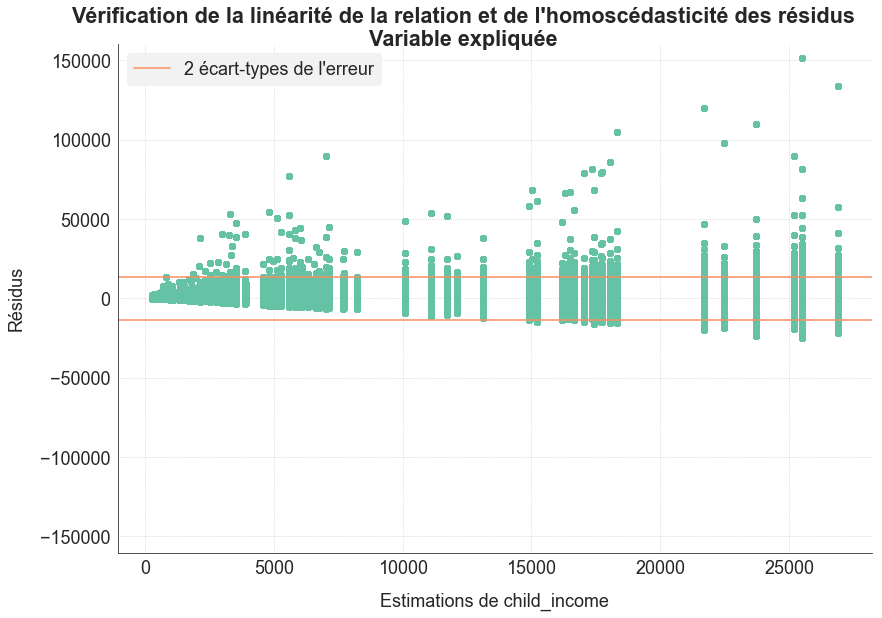

In [12]:
mygraph = sfg.MyGraph("Vérification de la linéarité de la relation et de l'homoscédasticité des résidus\nVariable expliquée", is_mono=False)
mygraph.add_plot(anova.fittedvalues, anova.resid, label="", marker='o', linestyle='', with_grid='both', grid_style=":")
yseuil = 2 * np.sqrt(table_anova.loc["Residual","sum_sq"] / table_anova.loc["Residual","df"])
mygraph.add_line(-yseuil, vertical=False, color=mygraph.liste_couleurs[1])
mygraph.add_line(yseuil, vertical=False, label="2 écart-types de l'erreur", color=mygraph.liste_couleurs[1], legend=True)
ymin, ymax = mygraph.ax[0].get_ylim()
absmax = max(-ymin, ymax, 1.1*yseuil)
mygraph.set_axe('x', label="Estimations de child_income")
mygraph.set_axe('y', label="Résidus", tick_min=-absmax, tick_max=absmax)
fig, ax = mygraph.fig, mygraph.ax
plt.savefig("anova03_03_linearite_homoscedasticite_endo.png")
plt.show()

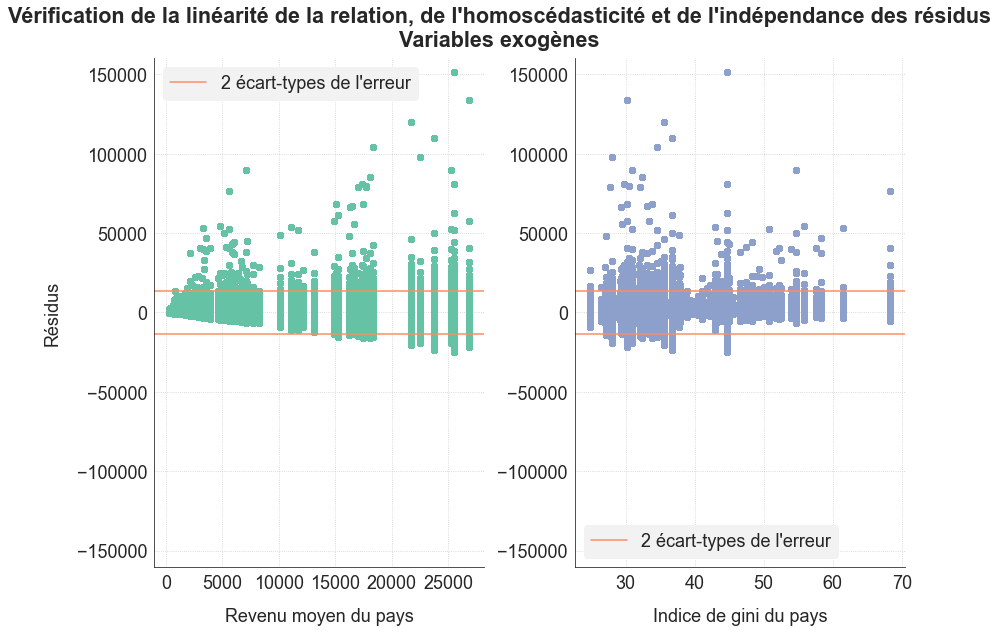

In [13]:
mygraph = sfg.MyGraph("Vérification de la linéarité de la relation, de l'homoscédasticité et de l'indépendance des résidus\nVariables exogènes", nblin=1, nbcol=2, is_mono=False)
mygraph.add_plot(data.revenu_moyen, anova.resid, label="", marker='o', color=mygraph.liste_couleurs[0], linestyle='', with_grid='both', grid_style=":", multi_index=1)
mygraph.add_plot(data.gini_from_centiles, anova.resid, label="", marker='o', color=mygraph.liste_couleurs[2], linestyle='', with_grid='both', grid_style=":", multi_index=2)
#yseuil = 2 * np.sqrt(table_anova.loc["Residual","sum_sq"] / table_anova.loc["Residual","df"])
mygraph.add_line(-yseuil, vertical=False, color=mygraph.liste_couleurs[1], multi_index=1)
mygraph.add_line(yseuil, vertical=False, label="2 écart-types de l'erreur", color=mygraph.liste_couleurs[1], legend=True, multi_index=1)
mygraph.add_line(-yseuil, vertical=False, color=mygraph.liste_couleurs[1], multi_index=2)
mygraph.add_line(yseuil, vertical=False, label="2 écart-types de l'erreur", color=mygraph.liste_couleurs[1], legend=True, multi_index=2)
ymin, ymax = mygraph.ax[0].get_ylim()
absmax = max(-ymin, ymax, 1.1*yseuil)
mygraph.set_axe('x', label="Revenu moyen du pays", multi_index=1)
mygraph.set_axe('x', label="Indice de gini du pays", multi_index=2)
mygraph.set_axe('y', label="Résidus", tick_min=-absmax, tick_max=absmax, multi_index=1)
mygraph.set_axe('y', tick_min=-absmax, tick_max=absmax, multi_index=2)
fig, ax = mygraph.fig, mygraph.ax
plt.savefig("anova03_04_linearite_homoscedasticite_exo.png")
plt.show()

In [14]:
alpha_homo = 0.05
lm_stat, lm_pvalue, f_stat, f_pvalue = sm.stats.diagnostic.het_breuschpagan(anova.resid, anova.model.exog)
if f_pvalue >= alpha_homo:
    test_result = ["Homoscédasticité acceptée"]
else:
    test_result = ["Homoscédasticité rejetée"]
pd.DataFrame({'H0':["Variance des résidus constante"], 'Statistique':["{:.2f}".format(f_stat)], \
             'p-value':["{:.3f}".format(f_pvalue)], 'Résultat (seuil={:.1%})'.format(alpha_homo):test_result}, index=["Breusch Pagan"])

,H0,Statistique,p-value,Résultat (seuil=5.0%)
Breusch Pagan,Variance des résidus constante,83835.07,0.000,Homoscédasticité rejetée


L'homoscédasticité est rejetée par le test. Les graphiques confirment les résultats du test, avec des résidus fortement décalés vers les valeurs positives élevées. L'hétéroscédasticité semble à nouveau découler de la non linéarité de la relation.

**Conclusion sur les hypothèses et sur le modèle**

Aucune des trois hypothèses n'est respectée. Il est inutile de pousser plus avant l'étude de ce modèle. L'utilisation des valeurs du logarithme des revenus (revenu de l'enfant et revenu moyen du pays) devrait fournir un modèle plus pertinent et exploitable.

---
**Vérifications supplémentaires par curiosité**

**Absence de colinéarité entre les exogènes**

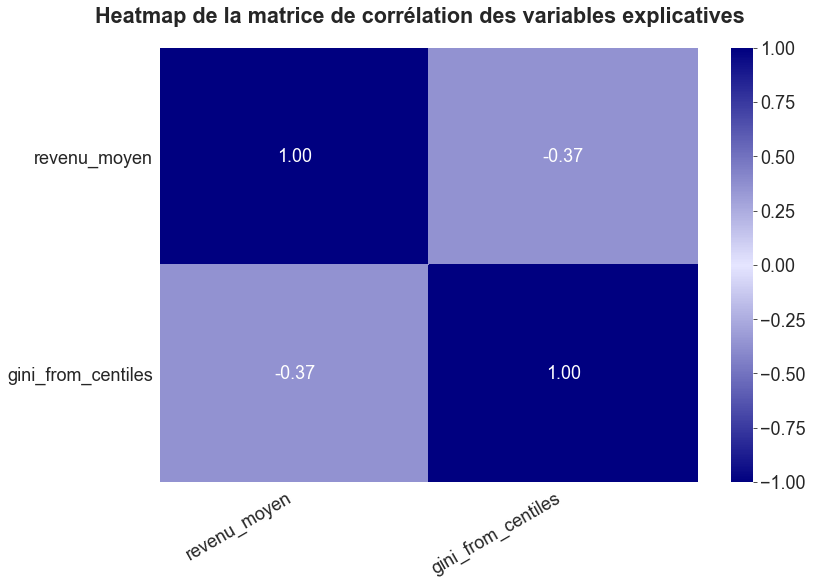

In [15]:
matrice_correl = np.corrcoef(data[["revenu_moyen","gini_from_centiles"]], rowvar=False)
mygraph = sfg.MyGraph("Heatmap de la matrice de corrélation des variables explicatives", is_mono=True)
sns.heatmap(matrice_correl, vmin=-1, vmax=1, fmt='.2f', cmap=plc.LinearSegmentedColormap.from_list("", [mygraph.liste_couleurs[-1],mygraph.liste_couleurs[0],mygraph.liste_couleurs[-1]]), \
            cbar_kws={'ticks':[-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]}, annot=True, ax=mygraph.ax[0])
mygraph.set_axe('y', tick_labels=["revenu_moyen","gini_from_centiles"], rotation=0)
mygraph.set_axe('x', tick_labels=["revenu_moyen","gini_from_centiles"], rotation=30, ha='right')
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
plt.savefig("anova03_05_matrice_correl.png")
plt.show()

In [16]:
variables = anova.model.exog
vif_analysis = pd.DataFrame([variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])], \
                          index=[var for var in anova.model.exog_names if var!="Intercept"], columns=["VIF"])
print("ANALYSE DE LA MULTI-COLINÉARITÉ (l'indice VIF doit être inférieur à 4)")
vif_analysis

ANALYSE DE LA MULTI-COLINÉARITÉ (l'indice VIF doit être inférieur à 4)


,VIF
revenu_moyen,1.154976
gini_from_centiles,1.154976


Les deux variables sont peu liées entre elles. Il n'y a pas de problème de colinéarité.

**Vérification de la pertinence des estimations par rapport aux valeurs réelles**

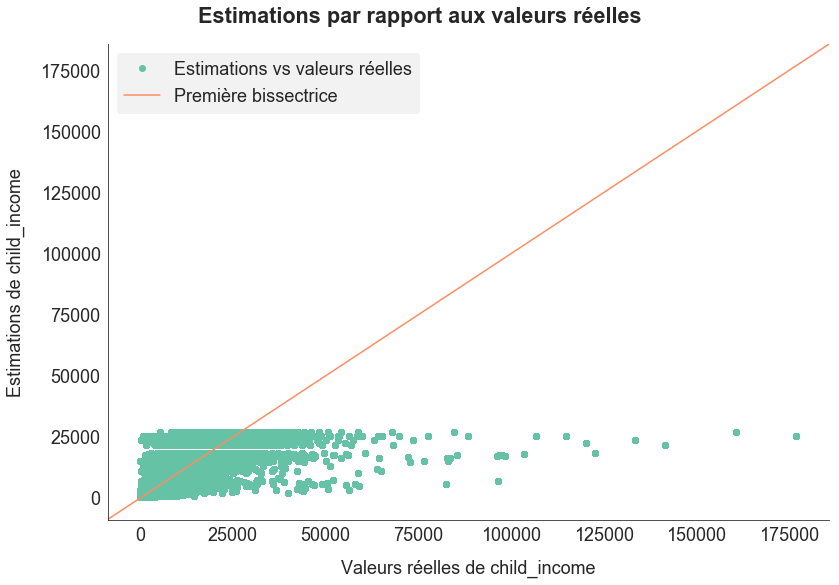

In [17]:
mygraph = sfg.MyGraph("Estimations par rapport aux valeurs réelles", is_mono=False)
mygraph.add_plot(data.child_income, anova.fittedvalues, label="Estimations vs valeurs réelles", marker='o', linestyle="")
ymin, ymax = mygraph.ax[0].get_ylim()
xmin, xmax = mygraph.ax[0].get_xlim()
data_min = min(xmin, ymin)
data_max = max(xmax, ymax)
mygraph.add_plot([data_min, data_max], [data_min, data_max], label="Première bissectrice", legend=True)
mygraph.set_axe('y', label="Estimations de child_income")
mygraph.set_axe('x', label="Valeurs réelles de child_income")
mygraph.ax[0].autoscale(enable=True, axis='both', tight=True)
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
plt.savefig("anova03_06_accuracy_graph.png")
plt.show()

Comme les analyses précédentes le supposent, les valeurs élevées de child income sont très mal évaluées par ce modèle. Elles devraient être mieux représentées en prenant le logarithme des revenus.

**Analyse des outliers**

In [18]:
n, p = anova.model.exog.shape
p = p - 1  # j'enlève la constante du nombre de paramètres pour ajuster les seuils
seuils = pd.Series(index=["levier", "resid_student", "dffits", "cook","dfbetas"])
seuils.levier = 2 * (p + 1) / n
seuils.dffits = 2 * np.sqrt((p + 1) / n)
seuils.cook = 4 / (n - p - 1)
seuils.resid_student = st.t.ppf(1-(0.05/2), n-p-2)  # seuil de 5% pour les résidus studentisés
reg_influence = anova.get_influence()
analyses = pd.DataFrame({"observation_name":data.index})
analyses["levier"] = reg_influence.hat_matrix_diag
#analyses["external_resid_student"] = reg_influence.resid_studentized_external
#analyses["outlier"] = ((analyses.levier > seuils.levier) | (abs(analyses.external_resid_student) > seuils.resid_student))
analyses["outlier"] = analyses.levier > seuils.levier
#analyses["dffits"] = reg_influence.dffits[0]
analyses["cook_distance"] = reg_influence.cooks_distance[0]
analyses["influence"] = analyses.cook_distance > seuils.cook
#analyses["influence"] = (abs(analyses.dffits) > seuils.dffits) | (analyses.cook_distance > seuils.cook)

In [19]:
seuils[["levier","cook"]].to_frame().style.format("{:.8f}")

,0
levier,0.00000106
cook,0.00000071


In [20]:
only_both = False
if only_both == False:
    print("Résumé des observations atypiques OU influentes")
    variables_speciales = analyses[(analyses.outlier | analyses.influence) & (analyses.outlier != analyses.influence)]
    print(variables_speciales)
    print("")
print("Résumé des observations atypiques ET influentes")
variables_investigation = analyses[analyses.outlier & analyses.influence]
variables_investigation

Résumé des observations atypiques OU influentes
         observation_name        levier  outlier  cook_distance  influence
98578               98578  2.948073e-07    False   7.442361e-07       True
98579               98579  2.948073e-07    False   7.442361e-07       True
98580               98580  2.948073e-07    False   7.442361e-07       True
98581               98581  2.948073e-07    False   7.442361e-07       True
98582               98582  2.948073e-07    False   7.442361e-07       True
98583               98583  2.948073e-07    False   7.442361e-07       True
98584               98584  2.948073e-07    False   7.442361e-07       True
98585               98585  2.948073e-07    False   7.442361e-07       True
98586               98586  2.948073e-07    False   7.442361e-07       True
98587               98587  2.948073e-07    False   7.442361e-07       True
98588               98588  2.948073e-07    False   7.442361e-07       True
98589               98589  2.948073e-07    False   7

,observation_name,levier,outlier,cook_distance,influence
748616,748616,0.000001,True,0.000006,True
748617,748617,0.000001,True,0.000006,True
748618,748618,0.000001,True,0.000006,True
748619,748619,0.000001,True,0.000006,True
748620,748620,0.000001,True,0.000006,True
748621,748621,0.000001,True,0.000006,True
748622,748622,0.000001,True,0.000006,True
748623,748623,0.000001,True,0.000006,True
748624,748624,0.000001,True,0.000006,True
748625,748625,0.000001,True,0.000006,True


Le nombre d'obervations soit atypiques soit influentes (mais pas à la fois atypiques et influentes) augmente (355 010 observations, soit 6,29% de l'échantillon).  
Nous avons désormais 163 351 observations à la fois atypiques et influentes. Il faudra vérifier si l'utilisation du logarithme des revenus corrige cela.